# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [1]:
import os
import csv
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import inspect
from tqdm import tqdm
from multiprocessing import Pool

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [2]:
# set up test parameters
dataset_dir = os.path.join('data', 'A37_analysis_test') # dataset directory
schema_path = os.path.join(dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

with open(os.path.join(dataset_dir,'metadata_ext.json'),'r') as json_file:
    annex_defaults = json.load(json_file)

In [3]:
# Set up base parameters of system.
ids = [0,3,9,11,12,15,16,25,26,32,38,44,45,48,49]

In [5]:
num_buildings = range(1,len(ids)+1)
runtimes = {}

for B in num_buildings:
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    print(f"# Buildings: {B}")

    base_kwargs = {
            'output_dir_path':dataset_dir,
            'building_names': ['UCam_Building_%s'%id for id in ids][:B],
            'battery_energy_capacities': [annex_defaults["building_attributes"]["battery_energy_capacities (kWh)"][str(id)] for id in ids][:B],
            'battery_power_capacities': [annex_defaults["building_attributes"]["battery_power_capacities (kW)"][str(id)] for id in ids][:B],
            'battery_efficiencies': [0.85]*B,
            'pv_power_capacities': [annex_defaults["building_attributes"]["pv_power_capacities (kW)"][str(id)] for id in ids][:B],
            'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids][:B],
            'weather_data_path': 'weather.csv',
            'carbon_intensity_data_path': 'carbon_intensity.csv',
            'pricing_data_path': 'pricing.csv',
            'schema_name': 'schema_temp'
        }

    schema_path = build_schema(**base_kwargs)

    # Initialise CityLearn environment object.
    env = CityLearnEnv(schema=schema_path)
    lp = LinProgModel(env=env)

    lp.set_time_data_from_envs()
    lp.generate_LP(clip_level='m',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
    lp.set_LP_parameters()

    start = time.time()
    lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
    end = time.time()

    print(lp_results['battery_capacities'],lp_results['solar_capacities'])

    runtimes.update({B: end-start})
    print(f"Solve time: {round(runtimes[B],1)}s")

2023-08-09 16:37:25
# Buildings: 1
[1751.25346574] [1056.4815295]
Solve time: 17.1s
2023-08-09 16:37:42
# Buildings: 2
[1754.68712609  126.01910736] [1057.63923157   91.93252796]
Solve time: 97.4s
2023-08-09 16:39:20
# Buildings: 3
[1754.68712609  126.01910736   26.65207726] [1057.63923157   91.93252796   23.16979028]
Solve time: 233.3s
2023-08-09 16:43:14
# Buildings: 4
[1751.25346574  124.62654802   26.64722756  927.73728492] [1056.4815295    91.59964675   23.16979028  661.26134874]
Solve time: 472.6s
2023-08-09 16:51:07
# Buildings: 5
[1751.25346574  125.39802019   26.65193204  928.2464427   239.71230186] [1056.4815295    91.73059042   23.17231638  658.87850467  155.0091287 ]
Solve time: 779.5s
2023-08-09 17:04:08
# Buildings: 6
[1746.81935754  124.55786909   26.62825556  924.25170666  238.21895761
  375.55207824] [1054.98651377   91.45742741   23.16979028  660.15037594  155.40540541
  231.99374383]
Solve time: 1353.3s
2023-08-09 17:26:42
# Buildings: 7
[1747.59176819  125.81966553 

In [6]:
print(runtimes)

{1: 17.130981922149658, 2: 97.37760543823242, 3: 233.32676362991333, 4: 472.6319968700409, 5: 779.5362808704376, 6: 1353.336327791214, 7: 2023.7432000637054, 8: 2846.3628962039948, 9: 4220.939216852188, 10: 5558.859155893326, 11: 7365.732852458954, 12: 8531.051749706268, 13: 9816.090405464172, 14: 11815.228953361511, 15: 14432.782981157303}


In [7]:
# Fit linear trend to log(runtime)
trend = np.polyfit(np.log(list(runtimes.keys())),np.log(list(runtimes.values())),deg=1)
print(trend)

[2.51541373 2.75738424]


In [8]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trend[1])/trend[0])
print(scenarios_limit)

58.11777295433248


In [9]:
from labellines import labelLines

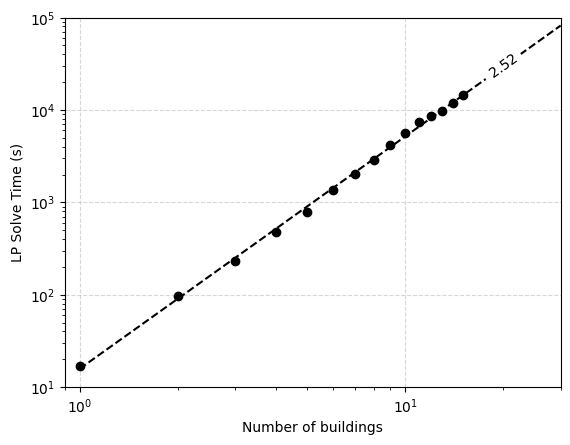

In [21]:
# Plot computational time results
max_scenarios = 30

fig,ax = plt.subplots()
ax.plot(runtimes.keys(),runtimes.values(),'ok')
ax.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trend[0] + trend[1]),'k--',label=round(trend[0],2))
plt.xlabel("Number of buildings")
plt.xscale('log')
plt.ylabel('LP Solve Time (s)')
plt.yscale('log')
plt.xlim(0.9,30)
plt.ylim(10,1e5)
plt.grid(True,'major',alpha=0.5,linestyle='--')
labelLines(ax.get_lines(),xvals=[20], fontsize=10, backgroundcolor='w')
plt.show()